In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.1.0 installed.
fastai version 2.0.16 installed.


In [3]:
from nbdev.showdoc import *
from fastai.vision.all import *

In [4]:
path = untar_data(URLs.IMAGENETTE_320)
path.ls()

(#2) [Path('/root/.fastai/data/imagenette2-320/train'),Path('/root/.fastai/data/imagenette2-320/val')]

Create a label dictionary to label the target variables

In [5]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [6]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

In [7]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=label_func,
                   splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                   item_tfms=RandomResizedCrop(224, min_scale=0.35),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])

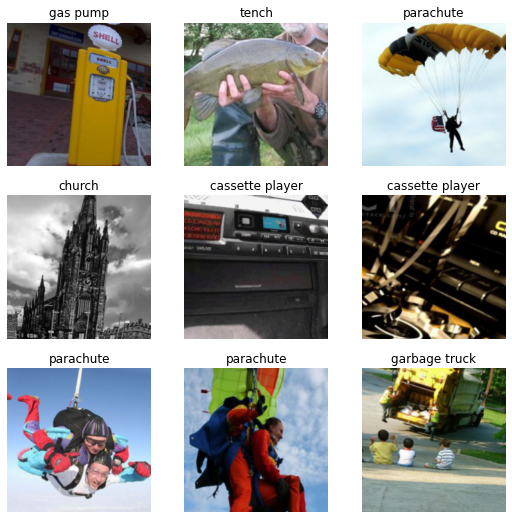

In [8]:
# Create a dataloaders object & display a small batch of samples
dls = dblock.dataloaders(path)
dls.show_batch()

Let's get one batch of data & check the shapes.
FastAI uses a default batchsize of 64

In [9]:
xb, yb = dls.one_batch()
print(f'Input shape: {xb.shape}, target shape: {yb.shape}.')

Input shape: torch.Size([64, 3, 224, 224]), target shape: torch.Size([64]).


Create the resnet model

In [10]:
## Input stem
conv_kwargs = {'kernel_size': 3, 'padding': 1, 'padding_mode': 'reflect', 'bias': False}

inp_stem = nn.Sequential(nn.Conv2d(3, 32, stride=2, **conv_kwargs),
                         nn.BatchNorm2d(32),
                         nn.ReLU(),
                         nn.Conv2d(32, 32, stride=1, **conv_kwargs),
                         nn.BatchNorm2d(32),
                         nn.ReLU(),
                         nn.Conv2d(32, 64, stride=1, **conv_kwargs),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                        )

In [11]:
## Resnet block
class ResNetBlock(nn.Module):
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.conv_path = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, stride=stride, **conv_kwargs),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            nn.Conv2d(ch_out, ch_out, stride=1, **conv_kwargs),
            nn.BatchNorm2d(ch_out)
           )
        self.id_path = []
        if ch_in != ch_out:
            # Use a Conv layer if the number of channels increase between the input & output.
            self.id_path.extend([nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, bias=False),
                                 nn.BatchNorm2d(ch_out)]
                               )
        if stride != 1:
            # Use AvgPooling if a stride is applied in the conv path.
            self.id_path = [nn.AvgPool2d(kernel_size=2, stride=2)] + self.id_path
        self.id_path = nn.Sequential(*self.id_path)

    def forward(self, xb):
        return nn.ReLU()(self.conv_path(xb) + self.id_path(xb))

In [12]:
# Resnet stages
stage1 = nn.Sequential(ResNetBlock(64, 64, stride=1),
                       ResNetBlock(64, 64, stride=1),
                       ResNetBlock(64, 64, stride=1)
                      )

stage2 = nn.Sequential(ResNetBlock(64, 128, stride=2),
                       ResNetBlock(128, 128, stride=1),
                       ResNetBlock(128, 128, stride=1),
                       ResNetBlock(128, 128, stride=1)
                      )

stage3 = nn.Sequential(ResNetBlock(128, 256, stride=2),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1),
                       ResNetBlock(256, 256, stride=1)
                      )

stage4 = nn.Sequential(ResNetBlock(256, 512, stride=2),
                       ResNetBlock(512, 512, stride=1),
                       ResNetBlock(512, 512, stride=1)
                      )

In [13]:
# The complete model
myresnet34 = nn.Sequential(
                           inp_stem,
                           nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                           stage1,
                           stage2,
                           stage3,
                           stage4,
                           nn.AdaptiveAvgPool2d(1),
                           nn.Flatten(),
                           nn.Linear(512, 10)
                          )

In [14]:
# A function to initialize weights & biases of the model
def kaiming_init(m):
    if getattr(m, 'bias', None) is not None:
        m.bias.data.zero_()
    if getattr(m, 'weight', None) is not None:
        if not isinstance(m, nn.BatchNorm2d):
            # BatchNorm layers are initialized with weight = 1. and bias=0. which is the reqd initialization for BatchNorm
            nn.init.kaiming_normal_(m.weight)
    for l in m.children():
        kaiming_init(l)

In [15]:
# Move the model to GPU if available & initialize the weights & biases:
if torch.cuda.is_available():
    myresnet34.to(device = 'cuda')
kaiming_init(myresnet34)

Create a learner using our own model.

In [16]:
learn = Learner(dls, myresnet34, metrics=accuracy)

In [17]:
doc(Learner)

In [18]:
learn.opt is None

True

In [19]:
doc(Optimizer)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.00019054606673307717)

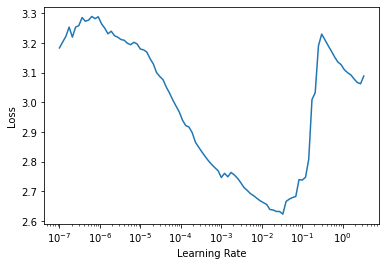

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(1, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.667703,1.431427,0.540637,01:24


In [22]:
print(f'type of param_list: {type(learn.opt.param_lists)}.')
print(f'Length of param_list: {len(learn.opt.param_lists)}.')
print(f"Length of the first object in param_lists: {len(learn.opt.param_lists[0])} and it's type: {type(learn.opt.param_lists[0])}.")

type of param_list: <class 'fastcore.foundation.L'>.
Length of param_list: 1.
Length of the first object in param_lists: 116 and it's type: <class 'fastcore.foundation.L'>.


Let's check the parameters next.

In [23]:
param_names = [k for p in learn.opt.param_lists[0] for k,v in learn.model.named_parameters() if v is p]
', '.join(param_names)

'0.0.weight, 0.1.weight, 0.1.bias, 0.3.weight, 0.4.weight, 0.4.bias, 0.6.weight, 0.7.weight, 0.7.bias, 2.0.conv_path.0.weight, 2.0.conv_path.1.weight, 2.0.conv_path.1.bias, 2.0.conv_path.3.weight, 2.0.conv_path.4.weight, 2.0.conv_path.4.bias, 2.1.conv_path.0.weight, 2.1.conv_path.1.weight, 2.1.conv_path.1.bias, 2.1.conv_path.3.weight, 2.1.conv_path.4.weight, 2.1.conv_path.4.bias, 2.2.conv_path.0.weight, 2.2.conv_path.1.weight, 2.2.conv_path.1.bias, 2.2.conv_path.3.weight, 2.2.conv_path.4.weight, 2.2.conv_path.4.bias, 3.0.conv_path.0.weight, 3.0.conv_path.1.weight, 3.0.conv_path.1.bias, 3.0.conv_path.3.weight, 3.0.conv_path.4.weight, 3.0.conv_path.4.bias, 3.0.id_path.1.weight, 3.0.id_path.2.weight, 3.0.id_path.2.bias, 3.1.conv_path.0.weight, 3.1.conv_path.1.weight, 3.1.conv_path.1.bias, 3.1.conv_path.3.weight, 3.1.conv_path.4.weight, 3.1.conv_path.4.bias, 3.2.conv_path.0.weight, 3.2.conv_path.1.weight, 3.2.conv_path.1.bias, 3.2.conv_path.3.weight, 3.2.conv_path.4.weight, 3.2.conv_path.4

In [24]:
p = learn.opt.param_lists[0][0]
p.shape

torch.Size([32, 3, 3, 3])

In [25]:
list(learn.model.named_children())

[('0', Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )),
 ('1',
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
 ('2', Sequential(
    (0): ResNetBlock(
      (conv_path): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

#### hypers

In [26]:
print(f'type of hypers: {type(learn.opt.hypers)}. type of first item inside hypers: {type(learn.opt.hypers[0])}.')
learn.opt.hypers

type of hypers: <class 'fastcore.foundation.L'>. type of first item inside hypers: <class 'dict'>.


(#1) [{'wd': 0.01, 'sqr_mom': 0.99, 'lr': 2.1297981542376006e-07, 'mom': 0.9499797018154758, 'eps': 1e-05}]

#### state

In [27]:
print(f'type of state: {type(learn.opt.state)}.')
print(f'Length of state: {len(learn.opt.state)}.')

type of state: <class 'dict'>.
Length of state: 116.


In [28]:
print(f'Length of all_params output: {len(learn.opt.all_params())}.')

Length of all_params output: 116.


The last layer in our model is a linear layer with 512 input activations and 10 output activations. Let's checkout the bias parameter of this layer as the bias is just a 1 dimensional tensor of length 10.

In [29]:
p, pg, state, hyper = learn.opt.all_params()[-1]
p.shape

torch.Size([10])

In [30]:
p

Parameter containing:
tensor([-0.0015,  0.0015, -0.0020,  0.0018,  0.0014, -0.0015,  0.0013, -0.0006,  0.0011,  0.0014], device='cuda:0', requires_grad=True)

In [31]:
state

{'do_wd': False,
 'grad_avg': tensor([-0.0036, -0.0062, -0.0117, -0.0002,  0.0090,  0.0059,  0.0075, -0.0222,  0.0092,  0.0122], device='cuda:0'),
 'sqr_avg': tensor([0.0014, 0.0012, 0.0014, 0.0012, 0.0013, 0.0014, 0.0013, 0.0014, 0.0013, 0.0017], device='cuda:0'),
 'step': 147}

In [32]:
len(dls.train)

147

State for a batchnorm parameter

In [33]:
p, pg, state, hyper = learn.opt.all_params()[-3]
p.shape

torch.Size([512])

In [34]:
state.keys()

dict_keys(['do_wd', 'force_train', 'grad_avg', 'sqr_avg', 'step'])

In [35]:
state['do_wd']

False

In [36]:
state['force_train']

True

In [37]:
p, pg, state, hyper = learn.opt.all_params()[-4]
p.shape, state.keys()

(torch.Size([512]),
 dict_keys(['do_wd', 'force_train', 'grad_avg', 'sqr_avg', 'step']))

In [38]:
state['do_wd'], state['force_train']

(False, True)

## Implementing Nadam Optimizer

FastAI optimizers use callback functions to update parameters & state variables during the opt.step() operation. The step() method calls all callbacks one after other on every trainable parameter of the model. These callbacks may update the parameter and/or may return new state values which will then be saved to the parameter's state.

In [39]:
## Callback for SGD Step
def sgd_step(p, lr, **kwargs):
    p.data.add_(p.grad.data, alpha=-lr)

In [40]:
## Callback for Weight Decay
def weight_decay(p, lr, wd, do_wd=True, **kwargs):
    "Weight decay as decaying `p` with `lr*wd`"
    if do_wd and wd!=0: p.data.mul_(1 - lr*wd)

weight_decay.defaults = dict(wd=0.)

In [41]:
## Callback for L2 Regularization
def l2_reg(p, lr, wd, do_wd=True, **kwargs):
    "L2 regularization as adding `wd*p` to `p.grad`"
    if do_wd and wd!=0: p.grad.data.add_(p.data, alpha=wd)

l2_reg.defaults = dict(wd=0.)

In [42]:
## Callback for average momentum
def average_grad(p, mom, dampening=False, grad_avg=None, **kwargs):
    "Keeps track of the avg grads of `p` in `state` with `mom`."
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    damp = 1-mom if dampening else 1.
    grad_avg.mul_(mom).add_(p.grad.data, alpha=damp)
    return {'grad_avg': grad_avg}

average_grad.defaults = dict(mom=0.9)

In [43]:
## Callback for average squared grad
def average_sqr_grad(p, sqr_mom, dampening=True, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    damp = 1-sqr_mom if dampening else 1.
    sqr_avg.mul_(sqr_mom).addcmul_(p.grad.data, p.grad.data, value=damp)
    return {'sqr_avg': sqr_avg}

average_sqr_grad.defaults = dict(sqr_mom=0.99)

In [44]:
def step_stat(p, step=0, **kwargs):
    "Register the number of steps done in `state` for `p`"
    step += 1
    return {'step' : step}

In [45]:
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

debias function return (1 - mom**step) if damp = (1-mom)

In [46]:
def nadam_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg, eps, **kwargs):
    set_trace()
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    num = grad_avg.mul(mom).add(p.grad.data, alpha=(1-mom))
    p.data.addcdiv_(num, (sqr_avg/debias2).sqrt() + eps, value=-lr/debias1)

In [47]:
from IPython.core.debugger import set_trace

In [48]:
def NAdam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-8, wd=0.01, decouple_wd=True):
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_grad, step_stat, nadam_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd)

Let's check our optimizer with a test parameter the FastAI way (see Optimizers in FastAI repo)

In [49]:
def test_param(x):
    x = torch.Tensor(x).float()
    x.requires_grad_(True)
    x.grad = torch.zeros_like(x)
    x.grad.data.fill_(0.1)
    return x

In [50]:
p1 = test_param([1, 2, 3])
p1, p1.grad

(tensor([1., 2., 3.], requires_grad=True), tensor([0.1000, 0.1000, 0.1000]))

In [51]:
# Let's create an optimizer for the test parameter p1
opt = NAdam(p1, lr=1)

In [52]:
opt.step()

> <ipython-input-46-4d7d5ec3e2fe>(3)nadam_step()
      1 def nadam_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg, eps, **kwargs):
      2     set_trace()
----> 3     debias1 = debias(mom,     1-mom,     step)
      4     debias2 = debias(sqr_mom, 1-sqr_mom, step)
      5     num = grad_avg.mul(mom).add(p.grad.data, alpha=(1-mom))

ipdb> p p, p.grad
(tensor([0.9900, 1.9800, 2.9700], requires_grad=True), tensor([0.1000, 0.1000, 0.1000]))
ipdb> p grad_avg, sqr_avg
(tensor([0.0100, 0.0100, 0.0100]), tensor([0.0001, 0.0001, 0.0001]))
ipdb> p mom, sqr_mom
(0.9, 0.99)
ipdb> p step, eps
(1, 1e-08)
ipdb> n
> <ipython-input-46-4d7d5ec3e2fe>(4)nadam_step()
      2     set_trace()
      3     debias1 = debias(mom,     1-mom,     step)
----> 4     debias2 = debias(sqr_mom, 1-sqr_mom, step)
      5     num = grad_avg.mul(mom).add(p.grad.data, alpha=(1-mom))
      6     p.data.addcdiv_(num, (sqr_avg/debias2).sqrt() + eps, value=-lr/debias1)

ipdb> n
> <ipython-input-46-4d7d5ec3e2fe>(5)nadam_step(

In [53]:
p1, p1.grad

(tensor([-0.9100,  0.0800,  1.0700], requires_grad=True),
 tensor([0.1000, 0.1000, 0.1000]))

Let's go for one more round

In [54]:
opt.step()

> <ipython-input-46-4d7d5ec3e2fe>(3)nadam_step()
      1 def nadam_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg, eps, **kwargs):
      2     set_trace()
----> 3     debias1 = debias(mom,     1-mom,     step)
      4     debias2 = debias(sqr_mom, 1-sqr_mom, step)
      5     num = grad_avg.mul(mom).add(p.grad.data, alpha=(1-mom))

ipdb> p p, p.grad
(tensor([-0.9009,  0.0792,  1.0593], requires_grad=True), tensor([0.1000, 0.1000, 0.1000]))
ipdb> p grad_avg, sqr_avg, step
(tensor([0.0190, 0.0190, 0.0190]), tensor([0.0002, 0.0002, 0.0002]), 2)
ipdb> p mom, sqr_mom, eps
(0.9, 0.99, 1e-08)
ipdb> n
> <ipython-input-46-4d7d5ec3e2fe>(4)nadam_step()
      2     set_trace()
      3     debias1 = debias(mom,     1-mom,     step)
----> 4     debias2 = debias(sqr_mom, 1-sqr_mom, step)
      5     num = grad_avg.mul(mom).add(p.grad.data, alpha=(1-mom))
      6     p.data.addcdiv_(num, (sqr_avg/debias2).sqrt() + eps, value=-lr/debias1)

ipdb> n
> <ipython-input-46-4d7d5ec3e2fe>(5)nadam_step()
   

In [55]:
p1, p1.grad

(tensor([-2.3272, -1.3471, -0.3670], requires_grad=True),
 tensor([0.1000, 0.1000, 0.1000]))

Now, let's fit our model with the Nadam optimizer we created

In [56]:
# The complete model
myresnet34 = nn.Sequential(
                           inp_stem,
                           nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                           stage1,
                           stage2,
                           stage3,
                           stage4,
                           nn.AdaptiveAvgPool2d(1),
                           nn.Flatten(),
                           nn.Linear(512, 10)
                          )

In [57]:
# Move the model to GPU if available & initialize the weights & biases:
if torch.cuda.is_available():
    myresnet34.to(device = 'cuda')
kaiming_init(myresnet34)

In [58]:
learn = Learner(dls, myresnet34, opt_func=NAdam, metrics=accuracy)

In [59]:
def nadam_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg, eps, **kwargs):
    #set_trace()
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    num = grad_avg.mul(mom).add(p.grad.data, alpha=(1-mom))
    p.data.addcdiv_(num, (sqr_avg/debias2).sqrt() + eps, value=-lr/debias1)

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=2.2908675418875646e-06)

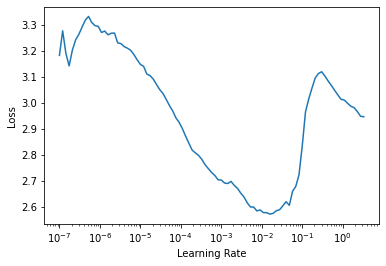

In [60]:
learn.lr_find()

In [61]:
learn.fit_one_cycle(10, lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.742707,4.083780,0.322038,01:23
1,1.416018,4.050637,0.367389,01:23
2,1.249494,2.032570,0.451975,01:23
3,1.109854,1.694996,0.478726,01:23
4,0.993464,0.984363,0.682803,01:23
5,0.844132,1.072726,0.671083,01:23
6,0.770800,0.817914,0.733503,01:23
7,0.678430,0.658500,0.783949,01:23
8,0.599340,0.642977,0.791592,01:23
9,0.536506,0.607120,0.809682,01:24
